In [1]:
import nanomotif as nm
import logging as log
log.getLogger().setLevel(log.DEBUG)
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
padding = 12


# Intro

Documentation of considerations in the implementation of the candidate selection. 

The selection is based on the sequences around methylation sites on the contig. At each methylated position, a frame of n posiion on each side of the methylation side is extracted and the index within this subsequence is considered relative to the methylation position (range: -n to n or 0:n*2).

The initial approach for candidate selection is outlined here:

1. Sample random sequences in contig at canonical bases (e.g. A when 6mA i evaluated)
2. Calculate [PSSM](https://cs.rice.edu/~ogilvie/comp571/pssm/) (positional frequencies of bases) for contig sequences
3. Extract sequences in contig at all methylation sites
4. Set motif candidate to canonical base
2. While len(methylations sequences) > minimum sequences 
    - calculate PSSM for methylations sequences
    - Calculate KL-divergence from methylation PSSM to contig PSSM at each position
    - Select position in sequence with highest distance
    - Select most frequent base at this position
    - Add base to motif
    - Score new motif
    - if score > threshold
        - remove seuqences with motif from methylation sequences
        - keep motif
    - else
        - select sequences with motif from methylation sequences

This should grow a motif by incorporation the most informative positions and bases first. 

In [2]:
ec_assembly = nm.load_assembly("../data/ecoli/assembly.polished.fasta")
ec_pileup = nm.load_pileup("../data/ecoli/modkit.pileup.bed")

In [3]:
ec_motifs = nm.evaluate.process_sample(
    ec_assembly, 
    ec_pileup.pileup, 
    min_read_methylation_fraction = 0.8,
    min_valid_coverage = 10,
    min_kl_divergence = 0.2
)


INFO: Processing contig_3
INFO: Processing m
DEBUG: ....................C.................... | BetaBernoulliModel(alpha=8987993, beta=460823430) 
DEBUG: ....................CA................... | BetaBernoulliModel(alpha=3546121, beta=125264358) 
DEBUG: ....................C[AT]................... | BetaBernoulliModel(alpha=6857829, beta=216035773) 
DEBUG: ....................C..G................. | BetaBernoulliModel(alpha=3301127, beta=97540597) 
DEBUG: ....................CT................... | BetaBernoulliModel(alpha=3311708, beta=90771416) 
DEBUG: ....................C.G.................. | BetaBernoulliModel(alpha=5938195, beta=133651814) 
DEBUG: ...................CC.................... | BetaBernoulliModel(alpha=5297779, beta=86307467) 
DEBUG: ....................CTG.................. | BetaBernoulliModel(alpha=2725664, beta=38066827) 
DEBUG: ....................CAG.................. | BetaBernoulliModel(alpha=2791680, beta=37260518) 
DEBUG: ....................C[AT]G......

DEBUG: Loaded backend module://matplotlib_inline.backend_inline version unknown.
DEBUG: Loaded backend module://matplotlib_inline.backend_inline version unknown.
DEBUG: findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
DEBUG: findfont: score(FontEntry(fname='/shared_software/conda/envs/lx38ll@bio.aau.dk/nanomotif-dev/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizFiveSymReg.ttf', name='STIXSizeFiveSym', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG: findfont: score(FontEntry(fname='/shared_software/conda/envs/lx38ll@bio.aau.dk/nanomotif-dev/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/STIXNonUniBolIta.ttf', name='STIXNonUnicode', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
DEBUG: findfont: score(FontEntry(fname='/shared_software/conda/envs/lx38ll@bio.aau.dk/nanomotif-dev/lib/python3.9/site-packages/matplotlib/mp

DEBUG: findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0.
DEBUG: findfont: score(FontEntry(fname='/shared_software/conda/envs/lx38ll@bio.aau.dk/nanomotif-dev/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizFiveSymReg.ttf', name='STIXSizeFiveSym', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG: findfont: score(FontEntry(fname='/shared_software/conda/envs/lx38ll@bio.aau.dk/nanomotif-dev/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/STIXNonUniBolIta.ttf', name='STIXNonUnicode', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
DEBUG: findfont: score(FontEntry(fname='/shared_software/conda/envs/lx38ll@bio.aau.dk/nanomotif-dev/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSerifDisplay.ttf', name='DejaVu Serif Display', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
D

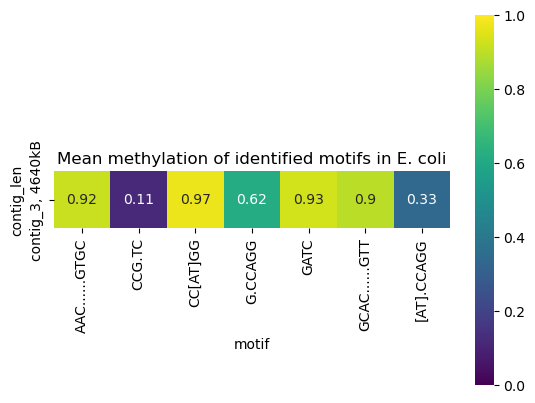

In [ ]:
ec_motifs_plot = ec_motifs \
    .with_columns([
        pl.col("model").apply(lambda model: model.mean()).alias("mean"),
        pl.col("contig").apply(lambda 
                               contig: f"{contig}, {len(ec_assembly.assembly[contig])/ 1e3:.0f}kB").alias("contig_len"),
    ]).sort("motif", descending = True)
heatmap = sns.heatmap(ec_motifs_plot.to_pandas().pivot(values = "mean", index = "contig_len", columns = "motif"), 
                      cmap = "viridis", square=True, vmin = 0.0, vmax = 1.0, annot = True);
heatmap.set_facecolor('lightgray');
plt.title("Mean methylation of identified motifs in E. coli");
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=90);

# M. ruber

In [2]:
mr_assembly = nm.load_assembly("../data/mruber/assembly.polished.fasta")
mr_pileup = nm.load_pileup("../data/mruber/modkit.pileup.bed")

In [3]:
mr_motifs = nm.evaluate.process_sample(mr_assembly, mr_pileup.pileup.filter(pl.col("mod_type")=="a"), 
    min_read_methylation_fraction = 0.80,
    min_valid_coverage = 10,
    min_kl_divergence = 0.2
    )

INFO: Processing contig_1
INFO: Processing a
DEBUG: ....................A.................... | BetaBernoulliModel(alpha=39221130, beta=330475809) 
DEBUG: ....................AG................... | BetaBernoulliModel(alpha=14843609, beta=108050640) 
DEBUG: ....................AGC.................. | BetaBernoulliModel(alpha=5633662, beta=41642955) 
DEBUG: ....................AG[GC].................. | BetaBernoulliModel(alpha=12284494, beta=79062975) 
DEBUG: ..................C.AGC.................. | BetaBernoulliModel(alpha=2615165, beta=15102645) 
DEBUG: ..................C.AG................... | BetaBernoulliModel(alpha=7090733, beta=40901662) 
DEBUG: ....................A[TG]................... | BetaBernoulliModel(alpha=26324402, beta=162661445) 
DEBUG: ....................AGG.................. | BetaBernoulliModel(alpha=6650832, beta=37420021) 
DEBUG: .................T..A.................... | BetaBernoulliModel(alpha=11675462, beta=64579328) 
DEBUG: ................C...AGC..

DEBUG: locator: <matplotlib.ticker.AutoLocator object at 0x7fe6367cb130>


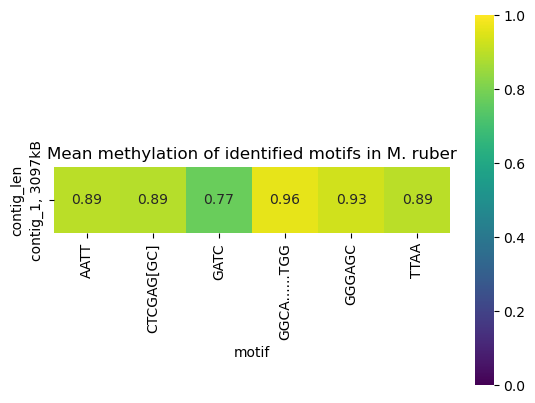

In [5]:
mr_motifs_plot = mr_motifs \
    .with_columns([
        pl.col("model").apply(lambda model: model.mean()).alias("mean"),
        pl.col("contig").apply(lambda contig: f"{contig}, {len(mr_assembly.assembly[contig])/ 1e3:.0f}kB").alias("contig_len"),
    ]).sort("motif", descending = True)
cmap = sns.cubehelix_palette(as_cmap=True, light=.9)
heatmap = sns.heatmap(mr_motifs_plot.to_pandas().pivot(values = "mean", index = "contig_len", columns = "motif"), 
                      cmap = "viridis", square=True, vmin = 0, vmax = 1, annot = True);
heatmap.set_facecolor('lightgray');
plt.title("Mean methylation of identified motifs in M. ruber");

# Geobacillus

In [2]:
gb_assembly = nm.load_assembly("../data/geobacillus/assembly.polished.fasta")
gb_pileup = nm.load_pileup("../data/geobacillus/modkit.pileup.bed")

In [3]:
gb_motifs = nm.evaluate.process_sample(
    gb_assembly, 
    gb_pileup.pileup.filter(pl.col("mod_type") == "a"), 
    max_candidate_size = 30, 
    min_valid_coverage=5,
    min_kl_divergence=0.1, 
    min_read_methylation_fraction = 0.8
    )

INFO: Processing contig_1
INFO: Processing a
DEBUG: ...............A............... | BetaBernoulliModel(alpha=13418780, beta=271623843) 
DEBUG: ...............AT.............. | BetaBernoulliModel(alpha=6597069, beta=79365424) 
DEBUG: ..............GA............... | BetaBernoulliModel(alpha=5075677, beta=57559775) 
DEBUG: ...............A.C............. | BetaBernoulliModel(alpha=5420041, beta=53161981) 
DEBUG: ..............GAT.............. | BetaBernoulliModel(alpha=3586930, beta=15579660) 
DEBUG: ...............ATC............. | BetaBernoulliModel(alpha=3797930, beta=15217442) 
DEBUG: ..............GA.C............. | BetaBernoulliModel(alpha=3352170, beta=8441448) 
DEBUG: ..............GATC............. | BetaBernoulliModel(alpha=3067969, beta=417395) 
INFO: ..............GATC............., 23103 seqs. model: BetaBernoulliModel(alpha=3067969, beta=417395). (27.2 % left)
INFO: Continuing search
DEBUG: ...............A............... | BetaBernoulliModel(alpha=13418780, beta=271

KeyboardInterrupt: 

In [ ]:
gb_motifs

In [ ]:
log.basicConfig(level=log.INFO);
gb_motifs_plot = gb_motifs \
    .with_columns([
        pl.col("model").apply(lambda model: model.mean()).alias("mean"),
        pl.col("contig").apply(lambda contig: f"{contig}, {len(gb_assembly.assembly[contig])/ 1e3:.0f}kB").alias("contig_len"),
        (pl.col("motif") + pl.col("mod_position").cast(pl.Utf8)).alias("motif_position")
    ]).sort("motif", descending = True)
cmap = sns.cubehelix_palette(as_cmap=True, light=.9)
heatmap = sns.heatmap(gb_motifs_plot.to_pandas().pivot(values = "mean", index = "contig_len", columns = "motif_position"), 
                      cmap = "viridis", square=True, vmin = 0, vmax = 1, annot = True);
heatmap.set_facecolor('lightgray')
plt.title("Mean methylation of identified motifs in Geobacillus");

# E. coli -dcm/-dam

In [ ]:
ecneg_assembly = nm.load_assembly("../data/ecoli_neg/assembly.polished.fasta")
ecneg_pileup = nm.load_pileup("../data/ecoli_neg/modkit.pileup.bed")

In [ ]:
ecneg_assembly.assembly.keys()

In [ ]:
ecneg_motifs = nm.evaluate.process_sample(ecneg_assembly, ecneg_pileup.pileup, min_read_methylation_fraction = 0)

# Combining results

In [ ]:
assemblies = {
    "E. coli K12": ec_assembly,
    "E. coli -dam/-dcm": ecneg_assembly,
    "Geobacillus": gb_assembly,
    "M. ruber": mr_assembly
}
pileups = {
    "E. coli K12": ec_pileup,
    "E. coli -dam/-dcm": ecneg_pileup,
    "Geobacillus": gb_pileup,
    "M. ruber": mr_pileup
}

In [ ]:
all_motifs = pl.concat([ec_motifs, mr_motifs, gb_motifs])
all_motifs_scored = {
    "sample":[],
    "contig":[],
    "type":[],
    "motif":[],
    "model":[],
    "mean":[],
    "score":[],
    "contig_length":[],
    "mod_position":[]
}
for sample, assembly in assemblies.items():

    pileup_filt = pileups[sample].pileup.filter(pl.col("Nvalid_cov") > 5) \
        .filter(pl.col("fraction_mod") > 0.80)
    for contig, contig_sequence in assembly.assembly.items():
        print(contig)
        pileup_filt_contig = pileup_filt.filter(pl.col("contig") == contig)
        for row in all_motifs.rows():
            print(row[-2])
            model = nm.evaluate.score_candidate(
                pileup_filt_contig.filter(pl.col("mod_type") == row[-3]),
                contig_sequence.sequence,
                row[-2],
                row[-1]
            )
            all_motifs_scored["sample"].append(sample)
            all_motifs_scored["contig"].append(contig)
            all_motifs_scored["motif"].append(row[-2])
            all_motifs_scored["model"].append(model)
            all_motifs_scored["mean"].append(model.mean())
            all_motifs_scored["score"].append(1 - model.cdf(0.55))
            all_motifs_scored["type"].append(row[-3])
            all_motifs_scored["contig_length"].append(len(contig_sequence.sequence))
            all_motifs_scored["mod_position"].append(row[-1])
all_motifs_scored

In [ ]:
motifs_all_samples = pl.DataFrame(all_motifs_scored) \
.with_columns(
    (pl.col("sample") + "\n" + (pl.col("contig_length")/1e3).cast(pl.Int16).cast(pl.Utf8) + "kb").alias("id"),
    (pl.col("motif") + "_" + pl.col("type")+ "_" + pl.col("mod_position").cast(pl.Utf8)).alias("motif_mod_type")
)
motifs_all_samples

In [ ]:
cmap = sns.cubehelix_palette(as_cmap=True, light=.8)
heatmap = sns.clustermap(
    motifs_all_samples.to_pandas().reset_index().drop_duplicates(subset=['id', 'motif_mod_type'], keep='last').pivot(values = "score", index = "id", columns = "motif_mod_type"), 
    cmap = "viridis", vmin = 0, vmax = 1,
    row_cluster=True, col_cluster=True, dendrogram_ratio=0.15, figsize = (8, 8));
heatmap.ax_heatmap.yaxis.set_ticklabels(heatmap.ax_heatmap.yaxis.get_ticklabels(), rotation=0, ha='left');

In [ ]:
motifs_all_samples

In [ ]:
motifs_all_samples \
        .to_pandas().reset_index().drop_duplicates(subset=['id', 'motif_mod_type'], keep='last') \
        .pivot(values = "mean", index = "id", columns = "motif_mod_type")

In [ ]:
sns.heatmap(
    motifs_all_samples \
        .to_pandas().reset_index().drop_duplicates(subset=['id', 'motif_mod_type'], keep='last') \
        .pivot(values = "mean", index = "id", columns = "motif_mod_type"),
    cmap="viridis",
    annot = True,
    square = True)

In [ ]:

cm_plot = sns.clustermap(
    motifs_all_samples \
        .with_columns(
            pl.col("mean").round(1).alias("mean_rounded")
        )
        .to_pandas().reset_index().drop_duplicates(subset=['id', 'motif_mod_type'], keep='last') \
        .pivot(values = "mean_rounded", index = "id", columns = "motif_mod_type"),
    cmap="viridis",
    tree_kws={"linewidths": 0.},
    cbar_kws={"label": "Degree of methylation"},
    cbar_pos=(0.84, 0.31, 0.014, 0.52),
    vmin=0,
    vmax=1,
    figsize=(10, 6),
    annot=True
    );
cm_plot.ax_heatmap.set_xlabel("motif, type, modifed position")
cm_plot.ax_heatmap.set_ylabel("")
cm_plot.ax_heatmap.yaxis.tick_left()